## Setup

## Torch setup
Install torch libraries that are needed to run
```python
import torch

import os
os.environ["TORCH"] = torch.__version__
```

```shell
!pip install torch_geometric
!pip install pytorch-lightning==2.4.0
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
```

## Other libraries
```shell
pip install matplotlib py3Dmol ipython
```

In [1]:
import os
import shutil

import ase
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol
from IPython.display import HTML

from mlfsm.cos import FreezingString
from mlfsm.geom import calculate_arc_length, project_trans_rot
from mlfsm.opt import CartesianOptimizer
from mlfsm.utils import load_xyz

## Manually load reactant and product

In [2]:
reactant = ase.Atoms(
    symbols=["C", "C", "H", "H", "H", "H", "H", "H"],
    positions=[
        [-0.7630691361, -0.0020190208, 0.0034566355],
        [0.7626325757, 0.0019950530, 0.0009730411],
        [-1.1589043116, -0.5118960388, 0.8883793728],
        [1.1613211937, 0.5116793524, 0.8847263259],
        [-1.1629572511, 1.0174805269, 0.0041985317],
        [-1.1617577754, -0.5117033851, -0.8802966057],
        [1.1625206820, -1.0175044968, 0.0002310876],
        [1.1584677813, 0.5118721300, -0.8839496535],
    ],
)
product = ase.Atoms(
    symbols=["C", "C", "H", "H", "H", "H", "H", "H"],
    positions=[
        [0.8250132507, -0.3044255156, -0.0001793369],
        [-0.0708590455, 0.6761106267, -0.0016038483],
        [-2.2168320223, -1.1357962646, 0.0051867426],
        [-2.9069107362, -1.4149124935, 0.0006665373],
        [1.2144012074, -0.7244594455, -0.9242788205],
        [1.2098231719, -0.7260043834, 0.9251338654],
        [-0.4588134959, 1.0959757755, 0.9230324730],
        [-0.4554227885, 1.0988459975, -0.9270321510],
    ],
)
# align product to reactant structure
_, aligned_product = project_trans_rot(reactant.get_positions(), product.get_positions())
product.set_positions(aligned_product.reshape(-1, 3))


# alternatively load one of the reactions in our benchmark set
# this loads the reactant and product structures and performs the alignment
reactant, product = load_xyz("data/06_diels_alder/")

# Run FSM

In [3]:
from schnet_ase_calculator import SchNetCalculator

# parameters
nnodes_min = 18
interp = "ric"
ninterp = 50
method = "L-BFGS-B"
maxiter = 1
maxls = 3
dmax = 0.3

# name the create output folder
run_name = "FSM_run"
outdir = f"{run_name}_Nodes_{nnodes_min}_interp_{interp}_maxiter_{maxiter}_maxls_{maxls}"
if not os.path.exists(outdir):
    os.makedirs(outdir)
else:
    shutil.rmtree(outdir)
    os.makedirs(outdir)

# load calculator
ckpt = "pre_trained_gnns/schnet_fine_tuned.ckpt"

calc = SchNetCalculator(checkpoint=ckpt)

# string class
string = FreezingString(reactant, product, nnodes_min, interp, ninterp)

# optimizer class
optimizer = CartesianOptimizer(calc, method, maxiter, maxls, dmax)

# run
while string.growing:
    string.grow()
    string.optimize(optimizer)
    string.write(outdir)
print("Gradient calls:", string.ngrad)

Lightning automatically upgraded your loaded checkpoint from v1.5.9 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint pre_trained_gnns/schnet_fine_tuned.ckpt`
/home/jevandezande/progs/ML-FSM/.pixi/envs/dev/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['model.atomic_mass']


NNODES_MIN: 18
DIST: 5.693 STEPSIZE: 0.316
ITERATION: 1 DIST: 4.81 ENERGY: [2.4 2.2 0.4 0.0]
ITERATION: 2 DIST: 4.23 ENERGY: [2.4 2.2 2.2 1.3 0.4 0.0]
ITERATION: 3 DIST: 3.61 ENERGY: [2.4 2.2 2.2 2.2 2.1 1.3 0.4 0.0]
ITERATION: 4 DIST: 3.01 ENERGY: [2.4 2.2 2.2 2.2 2.3 3.1 2.1 1.3 0.4 0.0]
ITERATION: 5 DIST: 2.39 ENERGY: [2.4 2.2 2.2 2.2 2.3 2.3 4.4 3.1 2.1 1.3 0.4 0.0]
ITERATION: 6 DIST: 1.77 ENERGY: [2.4 2.2 2.2 2.2 2.3 2.3 2.5 4.7 4.4 3.1 2.1 1.3 0.4 0.0]
ITERATION: 7 DIST: 1.17 ENERGY: [2.4 2.2 2.2 2.2 2.3 2.3 2.5 2.6 4.1 4.7 4.4 3.1 2.1 1.3 0.4 0.0]
ITERATION: 8 DIST: 0.56 ENERGY: [2.4 2.2 2.2 2.2 2.3 2.3 2.5 2.6 2.5 3.1 4.1 4.7 4.4 3.1 2.1 1.3 0.4 0.0]
ITERATION: 9 DIST: 0.23 ENERGY: [2.4 2.2 2.2 2.2 2.3 2.3 2.5 2.6 2.5 2.7 3.1 4.1 4.7 4.4 3.1 2.1 1.3 0.4
 0.0]
Gradient calls: 52


## Plotting and Visualization

In [4]:
all_atoms = string.r_string + string.p_string[::-1]
all_energies = np.array(string.r_energy + string.p_energy[::-1])
all_energies = all_energies - min(all_energies)
ts_idx = all_energies.argmax()
path = [structure.get_positions() for structure in all_atoms]
s = calculate_arc_length(np.array(path))

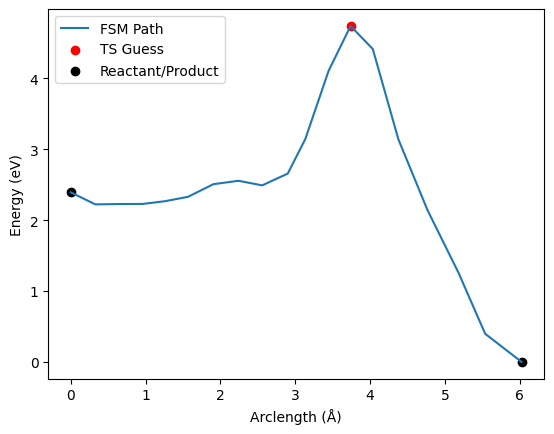

In [5]:
fig, ax = plt.subplots()
ax.plot(s, all_energies, label="FSM Path")
ax.scatter(s[ts_idx], all_energies[ts_idx], color="red", label="TS Guess")
ax.scatter(s[0], all_energies[0], color="black", label="Reactant/Product")
ax.scatter(s[-1], all_energies[-1], color="black")
ax.set_xlabel("Arclength (Å)")
ax.set_ylabel("Energy (eV)")
_ = ax.legend()

In [6]:
def snapshot_row(atoms_list: list[ase.Atoms], labels: list[str] | None = None) -> HTML:
    """Show selected structures."""
    html = []
    for i, atoms in enumerate(atoms_list):
        symbols = atoms.get_chemical_symbols()
        positions = atoms.get_positions()

        xyz_str = f"{len(atoms)}\n\n" + "\n".join(
            f"{sym} {x} {y} {z}" for sym, (x, y, z) in zip(symbols, positions, strict=True)
        )

        view = py3Dmol.view(width=250, height=250)
        view.addModel(xyz_str, "xyz")
        view.setStyle({"stick": {"radius": 0.2}, "sphere": {"radius": 0.6}})
        view.zoomTo()

        # Generate label and viewer together
        label_text = labels[i] if labels else f"Frame {i}"
        viewer_html = view._make_html()

        # Combine label and viewer in a single column
        html.append(
            f"""
<div style='display:flex;flex-direction:column;align-items:center;margin-right:10px'>
    <div style='font-weight:bold;margin-bottom:4px;text-align:center'>{label_text}</div>
    {viewer_html}
</div>"""
        )

    return HTML(f"<div style='display:flex;gap:10px'>{''.join(html)}</div>")


# Example usage
frames_to_show = [all_atoms[0], all_atoms[ts_idx], all_atoms[-1]]
custom_labels = [
    "Reactant<br> Relative Energy: {:.1f} eV".format(all_energies[0]),
    "TS Guess<br> Relative Energy: {:.1f} eV".format(all_energies[ts_idx]),
    "Product<br> Relative Energy: {:.1f} eV".format(all_energies[-1]),
]
snapshot_row(frames_to_show, custom_labels)